<a href="https://colab.research.google.com/github/dikshabhati1/song-lyrics-generator/blob/main/song_lyics_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf
 
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/song-lyrics.csv')

In [4]:
# first few rows
df.head()

,lyrics,song_name
0,Died last night in my dreams.Walking the stree...,Ghost Town
1,"Hey, slow it down.Whataya want from me?.Whatay...",Whataya Want From Me
2,Steel to my trembling lips.How did the night e...,Runnin’
3,I only trust my tarot cards.Pink flamingos in ...,Two Fux
4,Alone in the dark.Hole in my heart.Turn on the...,Another Lonely Night


In [5]:
# shape
df.shape

(683, 2)

I don't have much memory in this google colab.So we can't train the model on whole dataset.So I am going to take first 600 rows.If you have more memory in your local then go ahead and train the model on whole dataset

In [6]:
# take first 700 rows
df = df[:600]

In [7]:
# shape
df.shape

(600, 2)

In [8]:
df.to_csv('final_song_df.csv',index=False)

# Data Visualization

In [9]:
df['Number_of_words'] = df['lyrics'].apply(lambda x:len(str(x).split()))
df.head()

,lyrics,song_name,Number_of_words
0,Died last night in my dreams.Walking the stree...,Ghost Town,185
1,"Hey, slow it down.Whataya want from me?.Whatay...",Whataya Want From Me,271
2,Steel to my trembling lips.How did the night e...,Runnin’,266
3,I only trust my tarot cards.Pink flamingos in ...,Two Fux,310
4,Alone in the dark.Hole in my heart.Turn on the...,Another Lonely Night,184


In [10]:
# statistical info
df['Number_of_words'].describe()

count     600.000000
mean      279.651667
std       194.010766
min        37.000000
25%       152.000000
50%       229.000000
75%       337.500000
max      1374.000000
Name: Number_of_words, dtype: float64

So from above we can see the max length is 1384 and average song lyrics words length is 249

**Frequency distribution of number of words**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

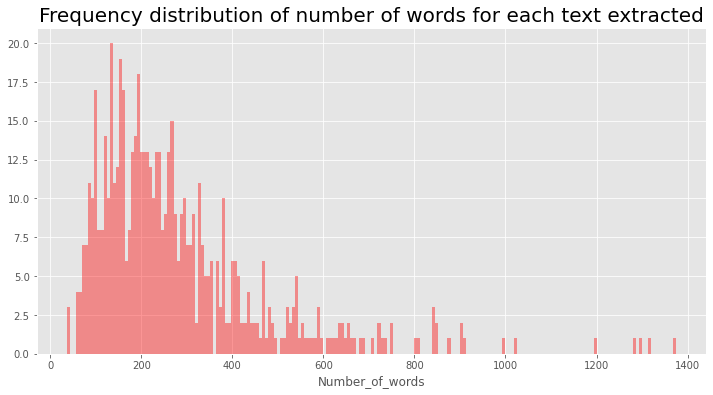

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

# Data Preprocessing

First of all we are going to do tokenization then we will generate sequence of n-grams.After that we will going to do padding.Padding is required because all the sentences are of different length so we need to make them of same length.We will going to do this by adding 0 in the beginning of the text with the help of pad_sequences function of keras

In [14]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['lyrics'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['lyrics'].astype(str))
tokenized_sentences[0]

[1467,
 234,
 86,
 10,
 8,
 415,
 512,
 2,
 819,
 15,
 94,
 157,
 843,
 356,
 3,
 639,
 6,
 300,
 10,
 321,
 5,
 2012,
 3350,
 22,
 2013,
 1569,
 49,
 390,
 23,
 15,
 2,
 1238,
 1128,
 31,
 2,
 4203,
 3,
 88,
 72,
 3351,
 1042,
 173,
 2,
 1382,
 820,
 49,
 14,
 187,
 22,
 83,
 46,
 33,
 1005,
 5,
 47,
 3,
 16,
 8,
 96,
 30,
 4,
 843,
 356,
 8,
 96,
 30,
 4,
 843,
 356,
 8,
 96,
 30,
 4,
 843,
 356,
 8,
 96,
 30,
 4,
 843,
 356,
 1467,
 234,
 86,
 10,
 8,
 415,
 23,
 2,
 3352,
 103,
 92,
 4204,
 54,
 46,
 2218,
 63,
 2,
 550,
 5,
 23,
 15,
 8,
 318,
 103,
 92,
 5757,
 47,
 12,
 1129,
 19,
 879,
 10,
 4,
 391,
 15,
 5758,
 4,
 391,
 15,
 5759,
 124,
 2494,
 30,
 615,
 5,
 4205,
 1239,
 5,
 24,
 30,
 4,
 5760,
 5,
 47,
 3,
 16,
 8,
 96,
 30,
 4,
 843,
 356,
 8,
 96,
 30,
 4,
 843,
 356,
 48,
 8,
 96,
 30,
 4,
 843,
 356,
 8,
 96,
 30,
 4,
 843,
 356,
 126,
 33,
 56,
 181,
 10,
 2,
 143,
 12,
 5761,
 18,
 90,
 4,
 112,
 38,
 3,
 41,
 51,
 51,
 51,
 3,
 35,
 4,
 969,
 10,
 8,
 295,
 13,
 88

In [15]:
total_words

10714

In [16]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [17]:
max_sequence_len

1564

In [18]:
input_sequences[:10]

array([[   0,    0,    0, ...,    0, 1467,  234],
       [   0,    0,    0, ..., 1467,  234,   86],
       [   0,    0,    0, ...,  234,   86,   10],
       ...,
       [   0,    0,    0, ...,  512,    2,  819],
       [   0,    0,    0, ...,    2,  819,   15],
       [   0,    0,    0, ...,  819,   15,   94]], dtype=int32)

For the model, we need to create predictors and label. We are going to create N-grams sequence as predictors and the next word of the N-gram as label.

In [19]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Model

We will not going to create RNN model due to its vanishing gradient problem instead of that we will going to create LSTM model.LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively.

In [22]:
# create model
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))

# earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')


In [29]:
checkpoint_path = "lstm-model.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train
history = model.fit(X,y,batch_size = 256 , epochs = 30 ,callbacks=[cp_callback])

Epoch 1/30
687/687 [==============================] - 214s 311ms/step - loss: 5.7224 - accuracy: 0.0803

Epoch 00001: saving model to lstm-model.ckpt
Epoch 2/30
687/687 [==============================] - 213s 310ms/step - loss: 5.2312 - accuracy: 0.1177

Epoch 00002: saving model to lstm-model.ckpt
Epoch 3/30
687/687 [==============================] - 213s 310ms/step - loss: 4.7916 - accuracy: 0.1519

Epoch 00003: saving model to lstm-model.ckpt
Epoch 4/30
687/687 [==============================] - 212s 309ms/step - loss: 4.4205 - accuracy: 0.1871

Epoch 00004: saving model to lstm-model.ckpt
Epoch 5/30
687/687 [==============================] - 212s 309ms/step - loss: 4.0980 - accuracy: 0.2247

Epoch 00005: saving model to lstm-model.ckpt
Epoch 6/30
687/687 [==============================] - 212s 309ms/step - loss: 3.8202 - accuracy: 0.2597

Epoch 00006: saving model to lstm-model.ckpt
Epoch 7/30
687/687 [==============================] - 212s 309ms/step - loss: 3.5766 - accuracy: 0.2

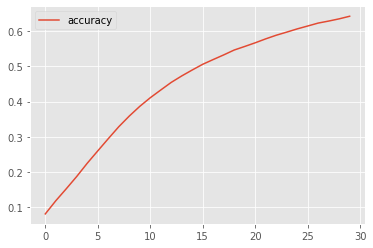

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

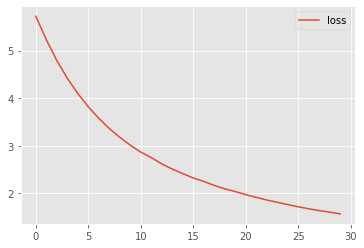

In [ ]:
# plot the accuracy
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

# Load Model

In [ ]:
# load weights
model.load_weights(checkpoint_path)

# Generate new song lyrics

Now our model is ready.So lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.

In [ ]:
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

Our function is ready so are you ready to generate your own lyrics

In [ ]:
complete_this_song("the sky is blue", 40)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"the sky is blue and she knows why i know and never know that i've been through the moon well they don't have to be a monument for me and i know it's not the one that i believe you die so far away"

In [ ]:
complete_this_song("This is the beginning", 140)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"This is the beginning of the world we made it out on the radio to the stars that can be where i can see the world is the burning to get the burning to feel the way i feel the one thing i feel the less you love it goes and i feel it seems in this way i am not the first time that takes the ways you see that i need you to be in the wings that i feel the way to be the one that i just feel the ones that we could get up the road but you get crazy but i know what you could be the first one day to the sun just to see it in the arms of the world just take me crazy oh woah oh it's the one thing the one thing i"

In [ ]:
complete_this_song("I am missing you", 80)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"I am missing you got to keep myself so but i've got nothing to hide the nights and the same carry on the stars go on a mind yo we're taking out where we should go how we do some we know we don't know they're true we don't know the same we can we know we are the same who we know we have to get out of me i can say i'm not the best of a metaphor i wanted a boogie"

In [ ]:
complete_this_song("Tell me something new", 200)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"Tell me something new wrong in me i need to be a brand new day and i see it in the code well i forgot those beats and they know the scene rise for the world they call on the road and i know that we should be gone and hope for me and i can see it all the time i see i know that i was going down and i know i should be in this world you gave me to you and then i think i can't move in all these things i gave was a life i know that everything is everything i was the one who knows me in the darkest place i'm on and i can't end when i'll say i'm far away i know to you now the way you bring me to you i know that i can see the world inside you can't let me fall you can't let me down you take me again you throw away again you throw away again you throw away away you love me but i always meant it you won't always be the one i've always always let go down i can feel your own to be the"

# Streamlit

In [ ]:
!pip install streamlit

In [ ]:
!pip install pyngrok

     |████████████████████████████████| 747kB 17.7MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.0.5-cp37-none-any.whl size=19246 sha256=ce9dcd3aa04a7dac3d5a04fffbb7eff4c394b8705e43b4d5f860b08a2e0af7a9
  Stored in directory: /root/.cache/pip/wheels/0c/13/64/5ebbcc22eaf53fdf5766b397c1fb17c83f5775fdccf0ea1b88
Successfully built pyngrok


In [ ]:
from pyngrok import ngrok

In [ ]:
%%writefile app.py
## Import libs

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import string
import numpy as np
from tensorflow.keras.models import  Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,LSTM ,Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
import warnings
warnings.filterwarnings('ignore')

import streamlit as st
import pickle
import time
import pandas as pd

import base64



## Read file
def main():
    st.markdown("<h1 style='text-align: center; color: red;'>Song Lyrics Generator</h1>", unsafe_allow_html=True)

    
    # Tokenization
    df = pd.read_csv("/content/final_song_df.csv")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

    
    # create model
    model = Sequential()
    model.add(Embedding(8556, 40, input_length=656-1))
    model.add(Bidirectional(LSTM(250)))
    model.add(Dropout(0.1))
    model.add(Dense(8556, activation='softmax'))
   


    ## Load model using checkpoint
    checkpoint_path = "lstm-model.ckpt"
    model.load_weights(checkpoint_path)


    ## predict func
    def complete_this_song(seed_text, next_words):
        for _ in range(next_words):
            # tokenizer = Tokenizer()
            token_list = tokenizer.texts_to_sequences([seed_text])[0]
            token_list = pad_sequences([token_list], maxlen=656-1, padding='pre')
            predicted = model.predict_classes(token_list, verbose=0)
        
            output_word = ""
            for word, index in tokenizer.word_index.items():
                if index == predicted:
                    output_word = word
                    break
            seed_text += " " + output_word
        return seed_text

    st.markdown("<h4 >Start your song lyrics:</h4>", unsafe_allow_html=True)
    seed_text = st.text_area('', height=200, max_chars=800)
    st.markdown("<h4 >Text length (in characters)</h4>", unsafe_allow_html=True)
    next_words = slider = st.slider('', 5, 800)
    button = st.button('Generate')


    if button:
        st.markdown(f"""<h3 style='text-align: center; color: white;background :rgba(12, 34, 255, 89);'> {complete_this_song(seed_text, next_words)}</h3>""", unsafe_allow_html=True)
 

if __name__ == "__main__":
    main()

Overwriting app.py


In [ ]:
public_url = ngrok.connect(port=80)

In [ ]:
print(public_url)
!streamlit run --server.port 80 app.py >/dev/null

NgrokTunnel: "http://a635dfd0e685.ngrok.io" -> "http://localhost:80"
2021-04-12 05:50:40.170 An update to the [server] config option section was detected. To have these changes be reflected, please restart streamlit.
2021-04-12 05:50:43.078 Unresolved object in checkpoint: (root).optimizer
2021-04-12 05:50:43.078 Unresolved object in checkpoint: (root).optimizer.iter
2021-04-12 05:50:43.078 Unresolved object in checkpoint: (root).optimizer.beta_1
2021-04-12 05:50:43.078 Unresolved object in checkpoint: (root).optimizer.beta_2
2021-04-12 05:50:43.078 Unresolved object in checkpoint: (root).optimizer.decay
2021-04-12 05:50:43.078 Unresolved object in checkpoint: (root).optimizer.learning_rate
2021-04-12 05:50:43.078 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings
2021-04-12 05:50:43.078 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.kernel
2021-04-12 05:50:43.078 Unresolved object in c